In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import tqdm
from time import sleep
import time
from PIL import Image
from io import BytesIO
from adjustText import adjust_text

from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name, get_teams, find_team_name_by_id
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, DrawingArea, TextArea
from matplotlib.patches import Circle, FancyArrowPatch, FancyArrow, ArrowStyle, Arrow, Rectangle
import matplotlib.ticker as mtick
from nba_api.stats.static.players import find_players_by_full_name, find_player_by_id



from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats
from collections import Counter

import json
from tqdm import tqdm

In [2]:
def convert_season_to_int(season):
    season = season.split('-')[0]
    return int(season) + 1

def convert_int_to_season(year):
    previos_year = year - 1
    year = str(year)
    previous_year = str(previos_year)
    year = year[-2:]
    return f'{previos_year}-{year}'

In [3]:
convert_int_to_season(2025)

print(list(range(2020, 2025)))

[2020, 2021, 2022, 2023, 2024]


In [4]:
all_pbp_df = pd.DataFrame()
all_shots_df = pd.DataFrame()
all_league_df = pd.DataFrame()
all_assist_df = pd.DataFrame()

for season in tqdm(range(2003, 2025)):
    
    str_season = convert_int_to_season(season)

    full_df = pd.read_csv(f'pbp_data/{str_season}.csv')

    full_df = full_df.fillna({
        "HOMEDESCRIPTION": "",
        "NEUTRALDESCRIPTION": "",
        "VISITORDESCRIPTION": ""
    })
    full_df.loc[:, 'GAME_ID'] = [f"00{item}" for item in full_df.GAME_ID.astype(str)]
    
    full_df['Season'] = str_season
    
    time.sleep(0.5)
    
#     shots = ShotChartDetail(team_id=0, player_id=0, context_measure_simple='FGM', season_nullable=str_season)

#     shots_df = shots.get_data_frames()[0]
    
#     shots_df['Season'] = str_season
    
    # time.sleep(0.5)
    
#     league_stats = LeagueDashPlayerStats(per_mode_detailed='PerGame', season=season, season_type_all_star='Regular Season')

#     league_df = league_stats.get_data_frames()[0]
    
    # all_pbp_df = pd.concat([all_pbp_df, full_df])
    # all_shots_df = pd.concat([all_shots_df, shots_df])
    # all_league_df = pd.concat([all_league_df, league_df])
    
    player_assists = full_df.loc[(full_df.PLAYER2_ID != 0) & (full_df.EVENTMSGTYPE == 1)]
    assists_combo = player_assists.groupby(['PLAYER1_ID', 'PLAYER2_ID', 'PLAYER1_NAME', 'PLAYER2_NAME']).size().reset_index()
    assists_combo = assists_combo.rename(columns={0: 'COUNT'})
    # assists_combo = assists_combo.sort_values(by='COUNT', ascending=False)

    assists_combo['Season'] = str_season
    all_assist_df = pd.concat([all_assist_df, assists_combo])

 82%|███████████████████████████████████▏       | 18/22 [00:51<00:11,  2.89s/it]/var/folders/wg/8c_xwvyn2tl18ply9w25rmgm0000gn/T/ipykernel_3956/41130044.py:10: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  full_df = pd.read_csv(f'pbp_data/{str_season}.csv')
100%|███████████████████████████████████████████| 22/22 [01:01<00:00,  2.82s/it]


In [5]:
all_assist_df.sort_values(by=['COUNT'], ascending=False)

,PLAYER1_ID,PLAYER2_ID,PLAYER1_NAME,PLAYER2_NAME,COUNT,Season
2122,2405,959,Amar'e Stoudemire,Steve Nash,282,2007-08
2931,201142,201566,Kevin Durant,Russell Westbrook,279,2010-11
1331,2405,959,Amar'e Stoudemire,Steve Nash,277,2009-10
2314,2430,101114,Carlos Boozer,Deron Williams,270,2007-08
1611,1888,1497,Richard Hamilton,Chauncey Billups,268,2005-06
...,...,...,...,...,...,...
105,1897,203135,Metta World Peace,Robert Sacre,1,2015-16
106,1897,203527,Metta World Peace,Ryan Kelly,1,2015-16
113,1938,1889,Manu Ginobili,Andre Miller,1,2015-16
126,1938,1626246,Manu Ginobili,Boban Marjanovic,1,2015-16


In [6]:
all_league_dash = pd.DataFrame()

for season in tqdm(range(2003, 2025)):
    
    str_season = convert_int_to_season(season)
    
    curr_league_stats = LeagueDashPlayerStats(per_mode_detailed='Totals', season=str_season, season_type_all_star='Regular Season').get_data_frames()[0]
    
    curr_league_stats['Season'] = str_season
        
    all_league_dash = pd.concat([all_league_dash, curr_league_stats])
    time.sleep(0.5)

100%|███████████████████████████████████████████| 22/22 [00:45<00:00,  2.07s/it]


In [7]:
all_league_dash[(all_league_dash.PLAYER_NAME == 'LeBron James') & (all_league_dash.Season == '2012-13')].AST

296    551
Name: AST, dtype: int64

/var/folders/wg/8c_xwvyn2tl18ply9w25rmgm0000gn/T/ipykernel_33650/4148510613.py:27: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  all_ast_in_season = int(all_league_dash[(all_league_dash.PLAYER_NAME == assister) & (all_league_dash.Season == season)].AST)


2003-04 - LeBron James -> Zydrunas Ilgauskas	: 104 / 465 	 22.37%
2004-05 - LeBron James -> Zydrunas Ilgauskas	: 122 / 577 	 21.14%
2005-06 - LeBron James -> Zydrunas Ilgauskas	: 111 / 521 	 21.31%
2006-07 - LeBron James -> Zydrunas Ilgauskas	: 92 / 470 	 19.57%
2007-08 - LeBron James -> Zydrunas Ilgauskas	: 121 / 539 	 22.45%
2008-09 - LeBron James -> Zydrunas Ilgauskas	: 114 / 587 	 19.42%
2009-10 - LeBron James -> Zydrunas Ilgauskas	: 64 / 651 	 9.83%
2010-11 - LeBron James -> Zydrunas Ilgauskas	: 57 / 554 	 10.29%
2010-11 - LeBron James -> Chris Bosh	: 120 / 554 	 21.66%
2011-12 - LeBron James -> Chris Bosh	: 88 / 387 	 22.74%
2012-13 - LeBron James -> Chris Bosh	: 132 / 551 	 23.96%
2013-14 - LeBron James -> Chris Bosh	: 142 / 488 	 29.1%
2014-15 - LeBron James -> Kevin Love	: 110 / 511 	 21.53%
2015-16 - LeBron James -> Kevin Love	: 126 / 514 	 24.51%
2016-17 - LeBron James -> Kevin Love	: 125 / 646 	 19.35%
2017-18 - LeBron James -> Kevin Love	: 141 / 747 	 18.88%
2019-20 - LeBr

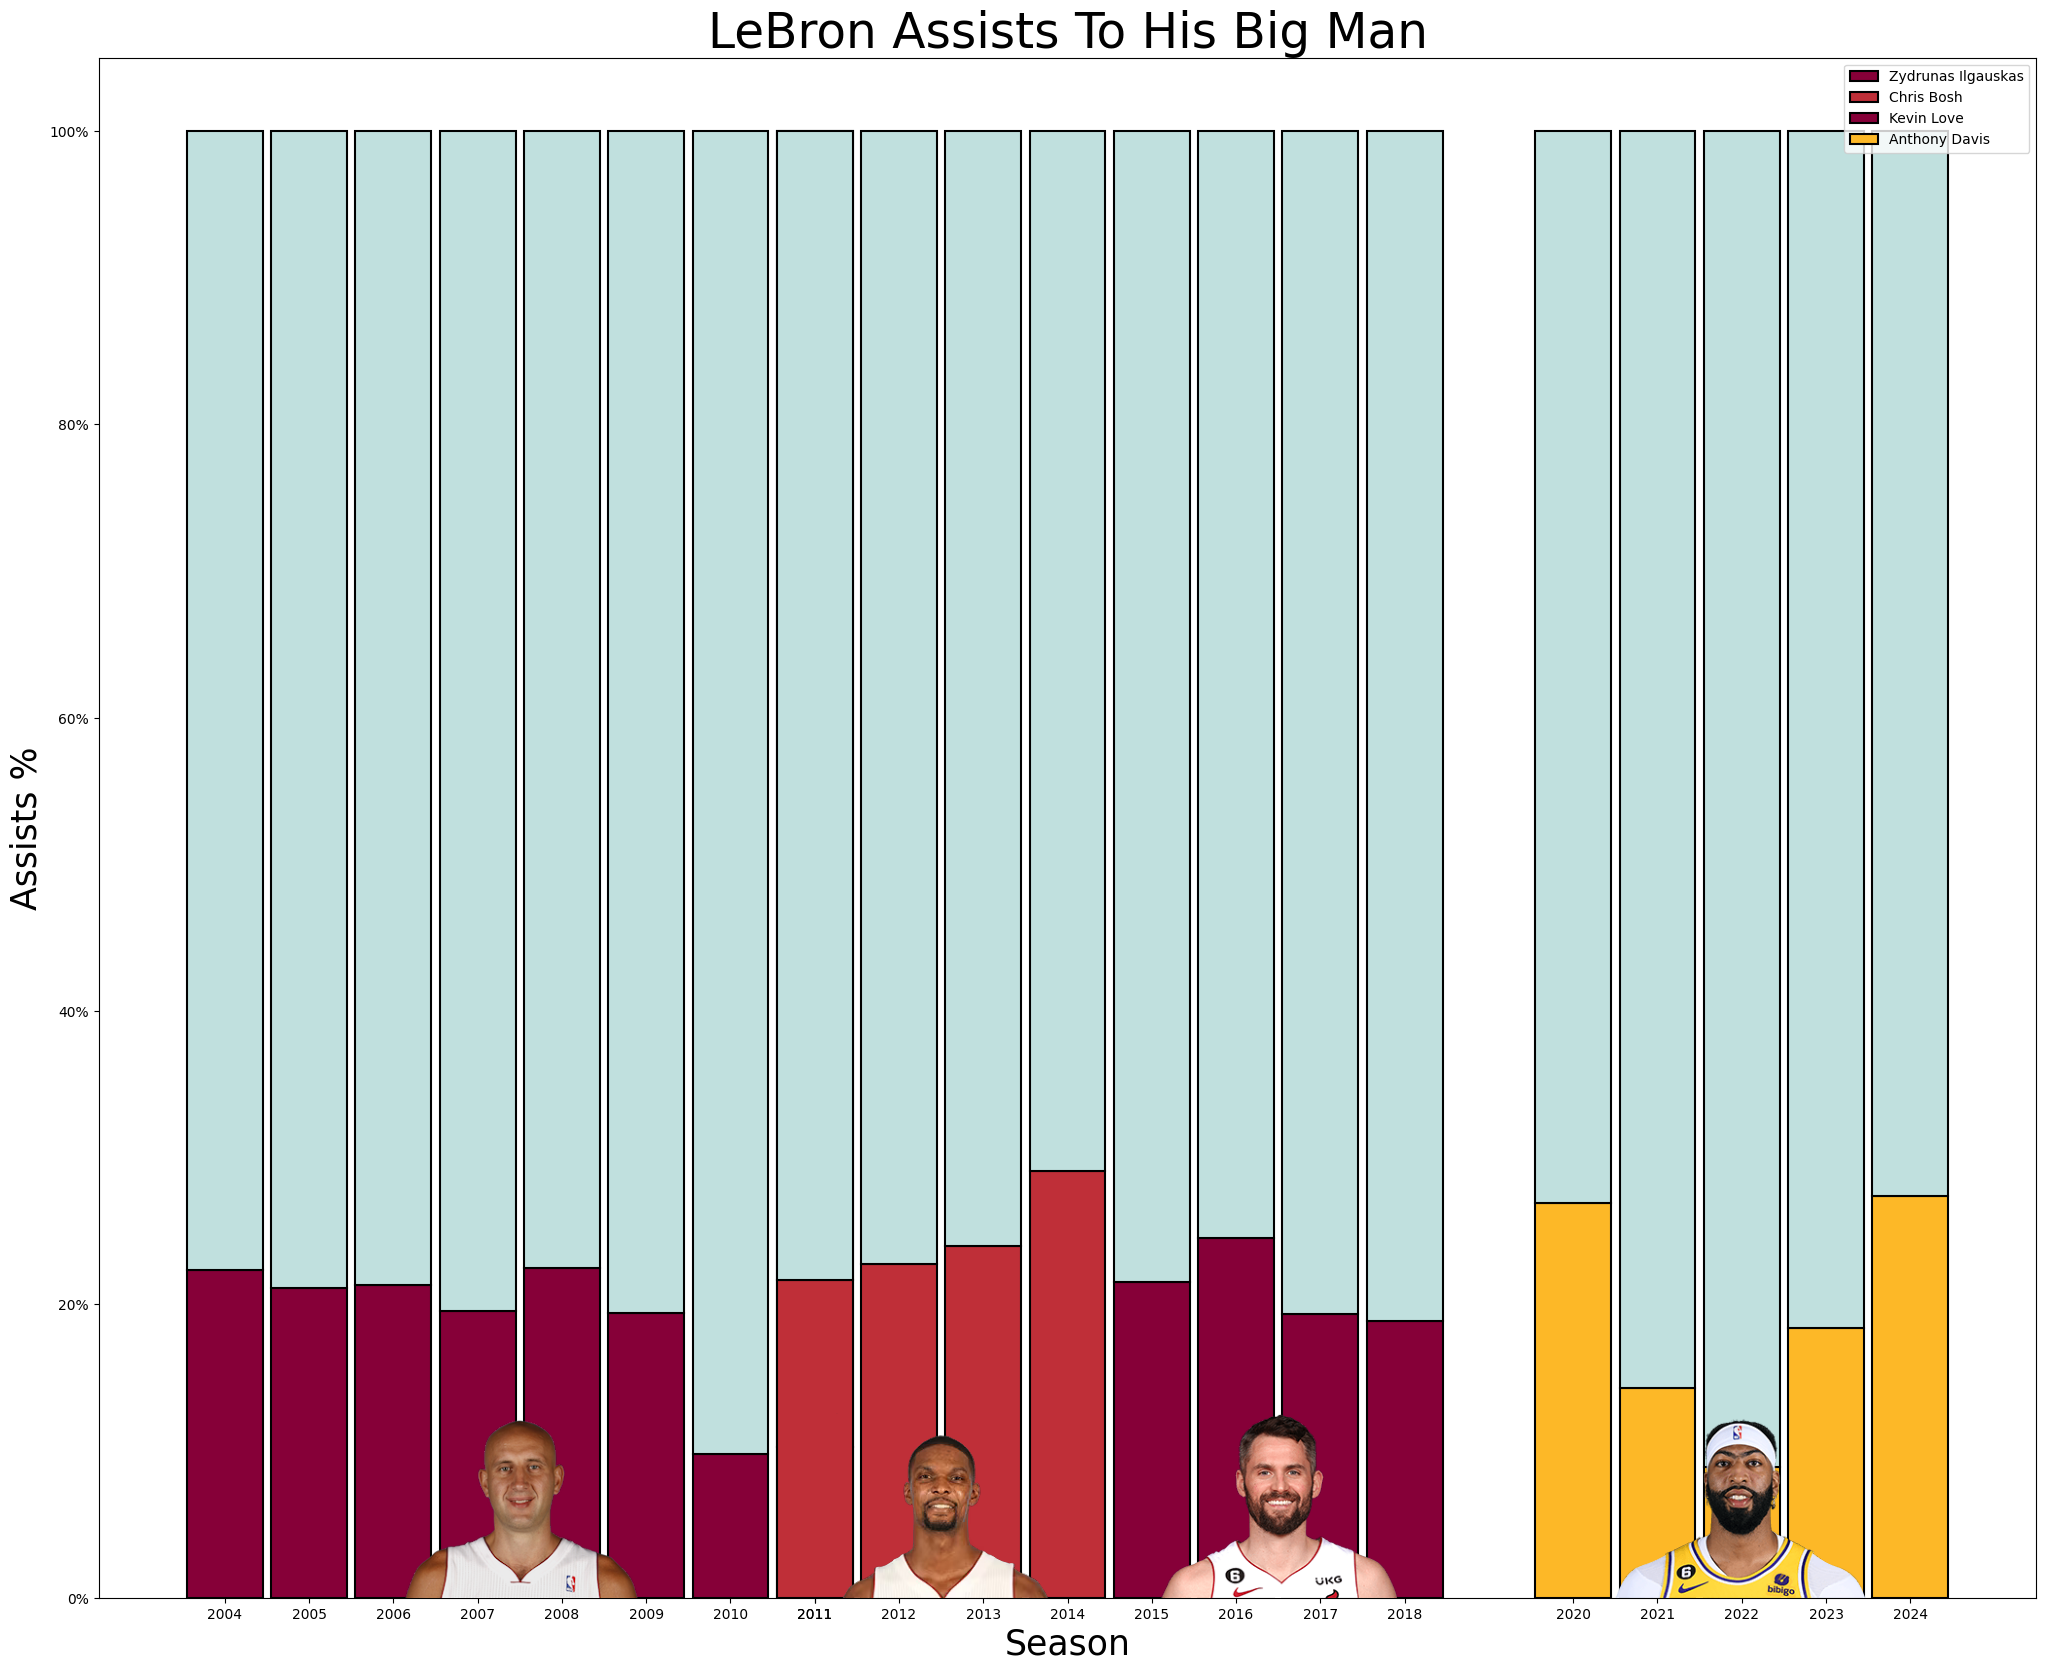

In [245]:
players = ['Zydrunas Ilgauskas', 'Chris Bosh', 'Kevin Love', 'Anthony Davis']


fig = plt.figure(figsize=(25,20))
ax = plt.subplot()

wide_made_color = "#4F7CAC"
wide_attempted_color = "#C0E0DE"

contested_made_color = "#99621E"
contested_attempted_color = "#D38B5D"

edge_color = "black"
linewidth = 1.5
width = 0.9
player_color = '#860038', '#BF2F38', '#860038', '#FDB827'

for j, player in enumerate(players):
    
    curr_player_color = player_color[j] 

    curr_df = all_assist_df[(all_assist_df.PLAYER2_NAME == 'LeBron James') & (all_assist_df.PLAYER1_NAME == player)]
    for i in range(len(curr_df)):
        item = curr_df.iloc[i]
        season, assister, scorer, count = item.Season, item.PLAYER2_NAME, item.PLAYER1_NAME, item.COUNT
        
        all_ast_in_season = int(all_league_dash[(all_league_dash.PLAYER_NAME == assister) & (all_league_dash.Season == season)].AST)
        print(f'{season} - {assister} -> {scorer}\t: {count} / {all_ast_in_season} \t {np.round((count / all_ast_in_season) * 100, 2)}%')
        
        season = convert_season_to_int(season)
        
        if i == 0:
            label1 = player
            label2 = 'Total AST'
        else:
            label1, label2 = None, None
            
        
        # ax.bar(season, count, color=curr_player_color, width=width, edgecolor=edge_color, linewidth=linewidth, label=label1)
        # ax.bar(season, all_ast_in_season - count, bottom=count, color=wide_attempted_color, width=width, edgecolor=edge_color, linewidth=linewidth)
        
        ast_pct = count / all_ast_in_season
        
        ax.bar(season, ast_pct * 100, color=curr_player_color, width=width, edgecolor=edge_color, linewidth=linewidth, label=label1)
        ax.bar(season, 100* ((all_ast_in_season - count) / all_ast_in_season), bottom=ast_pct * 100, color=wide_attempted_color, width=width, edgecolor=edge_color, linewidth=linewidth)

all_seasons = []

for player in players:
    curr_df = all_assist_df[(all_assist_df.PLAYER2_NAME == 'LeBron James') & (all_assist_df.PLAYER1_NAME == player)]
    seasons = curr_df.Season
    season_list = []
    for season in seasons:
        all_seasons.append(convert_season_to_int(season))
        season = convert_season_to_int(season)
        season_list.append(season)
    avg_szn = np.mean(season_list)
    
    ab = AnnotationBbox(get_player_img(find_players_by_full_name(player)[0]['id'], zoom=0.7), (avg_szn, 6.25), frameon=False)
    ax.add_artist(ab)
        
players = ['Anthony Davis']

# for player in players:

#     curr_df = all_assist_df[(all_assist_df.PLAYER2_NAME == 'Rajon Rondo') & (all_assist_df.PLAYER1_NAME == player)]
#     for i in range(len(curr_df)):
#         item = curr_df.iloc[i]
#         season, assister, scorer, count = item.Season, item.PLAYER2_NAME, item.PLAYER1_NAME, item.COUNT
#         all_ast_in_season = int(all_league_dash[(all_league_dash.PLAYER_NAME == assister) & (all_league_dash.Season == season)].AST)
#         print(f'{season} - {assister} -> {scorer}\t: {count} / {all_ast_in_season} \t {np.round((count / all_ast_in_season) * 100, 2)}%')
        
#         season = convert_season_to_int(season)

#         ax.bar(season + 0.75 / 2, count, color='#002A5C', width=width, edgecolor=edge_color, linewidth=linewidth, label=label1)
#         ax.bar(season + 0.75 / 2, all_ast_in_season - count, bottom=count, color=wide_attempted_color, width=width, edgecolor=edge_color, linewidth=linewidth, label=label2)
        
        
    
# print(curr_df.Season)

str_seasons = ['2010-11',
'2011-12',
'2012-13',
'2013-14',
'2014-15',
'2015-16',
'2016-17',
'2017-18',
'2019-20',
'2020-21',
'2021-22',
'2022-23',
'2023-24']
plt.legend()
ax.set_title('LeBron Assists To His Big Man', fontsize=35)
ax.set_ylabel('Assists %', fontsize=25)
ax.set_xlabel('Season', fontsize=25)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xticks(all_seasons)
# ax.set_xticklabels(str_seasons)

plt.savefig('Graphs/lebron_bigman.png', bbox_inches='tight')

/var/folders/wg/8c_xwvyn2tl18ply9w25rmgm0000gn/T/ipykernel_33650/2409360427.py:29: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  all_ast_in_season = int(all_league_dash[(all_league_dash.PLAYER_NAME == assister) & (all_league_dash.Season == season)].AST)


2017-18 - Rajon Rondo -> Anthony Davis	: 163 / 533 	 30.58%
2019-20 - Rajon Rondo -> Anthony Davis	: 57 / 240 	 23.75%
2021-22 - Rajon Rondo -> Anthony Davis	: 21 / 170 	 12.35%


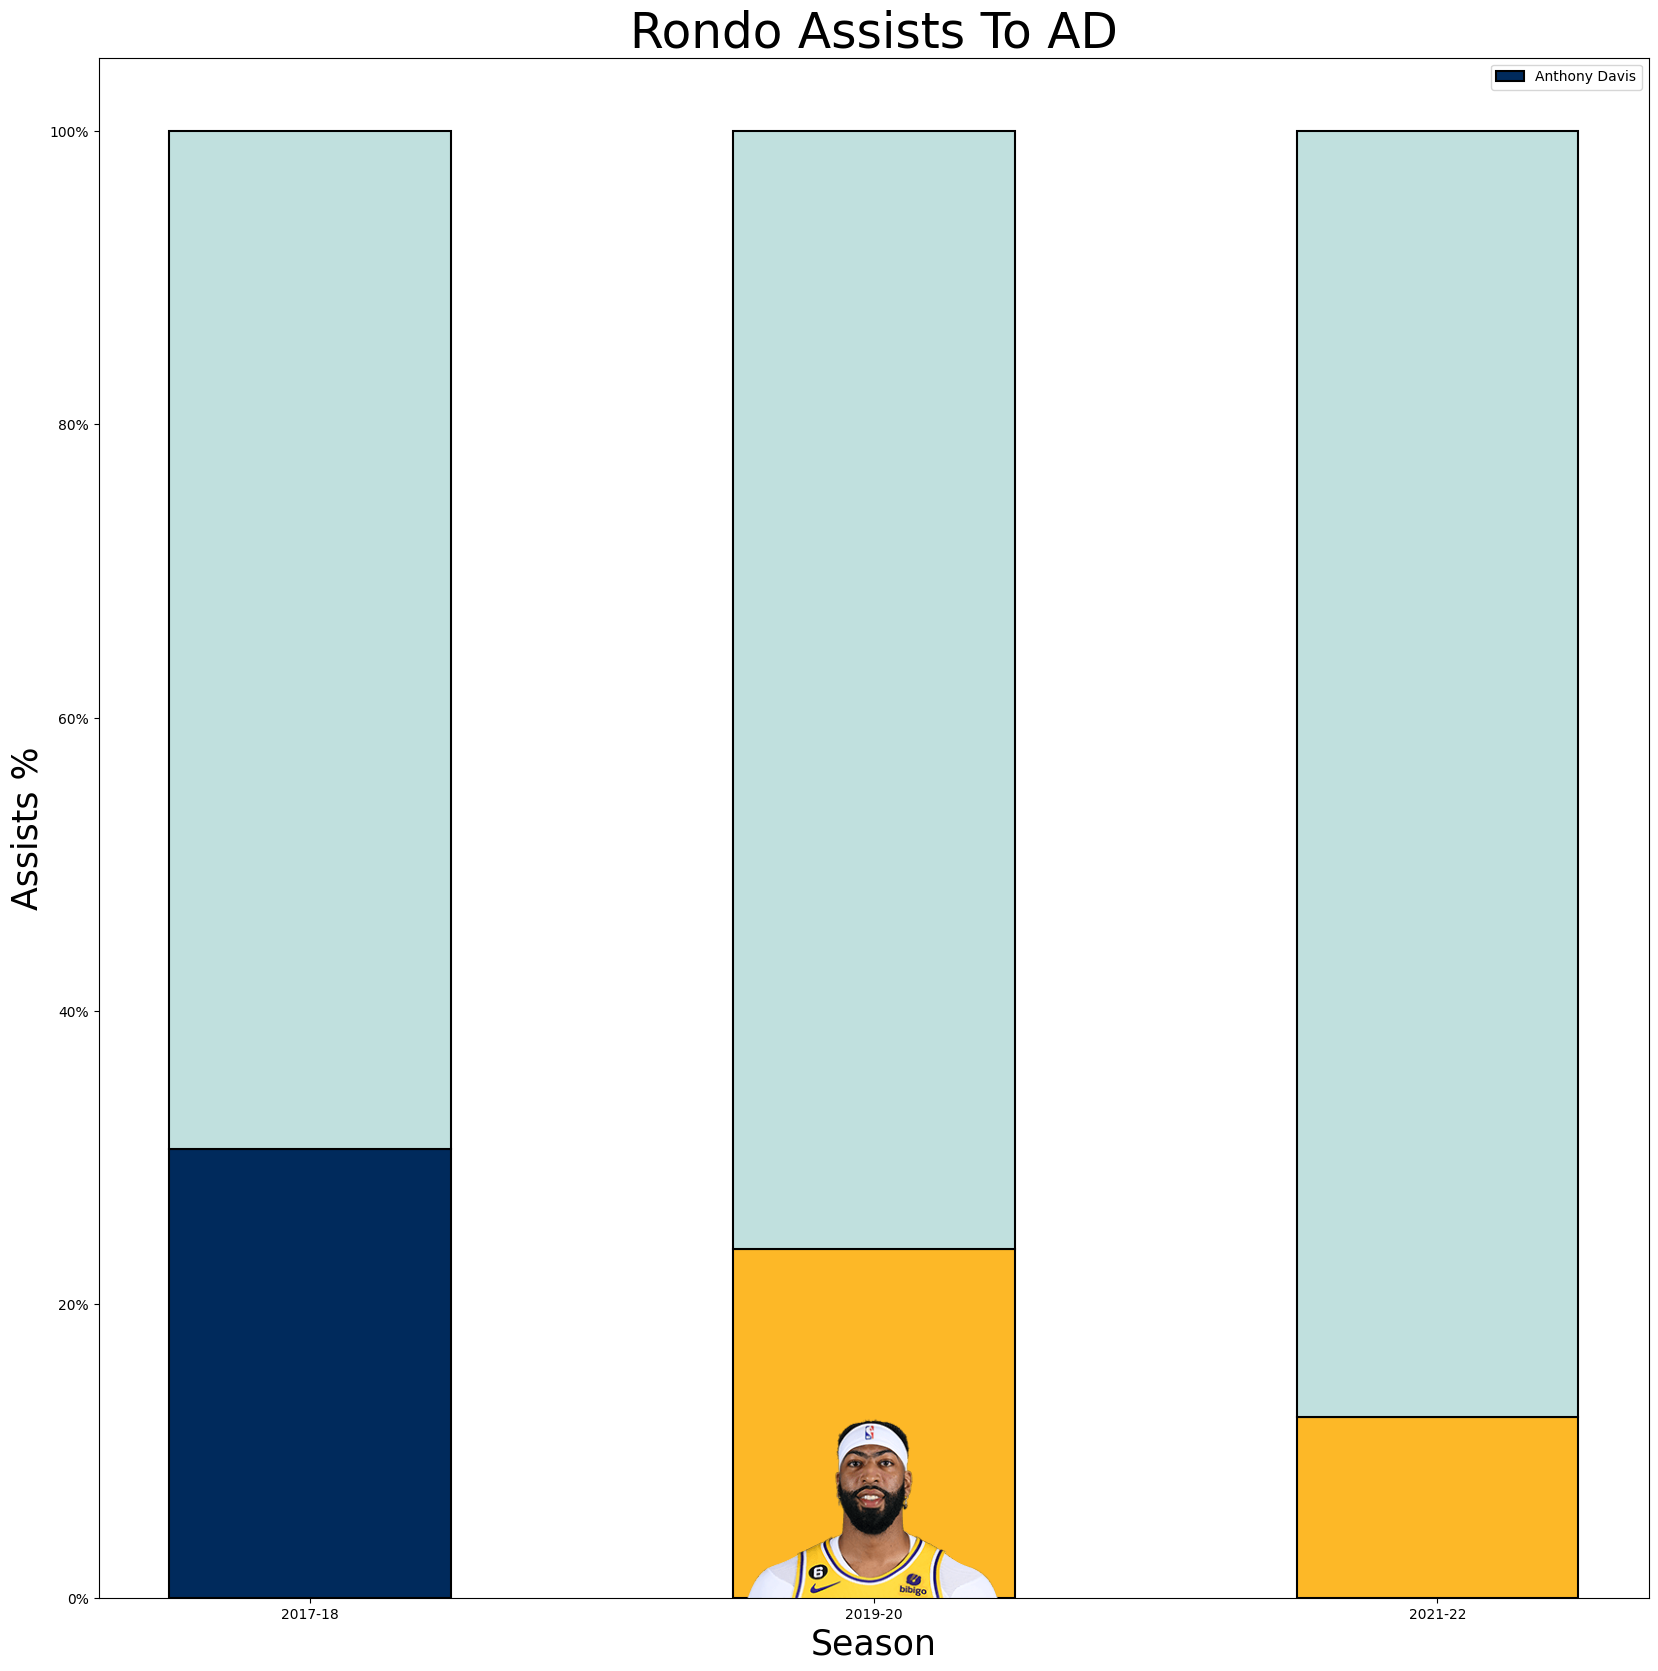

In [241]:
players = ['Anthony Davis']
# players = ['Chris Bosh', 'Kevin Love', 'Anthony Davis']


fig = plt.figure(figsize=(20,20))
ax = plt.subplot()

wide_made_color = "#4F7CAC"
wide_attempted_color = "#C0E0DE"

contested_made_color = "#99621E"
contested_attempted_color = "#D38B5D"

edge_color = "black"
linewidth = 1.5
width = 1
player_color = '#002A5C', '#FDB827', '#FDB827'

for j, player in enumerate(players):
    

    curr_df = all_assist_df[(all_assist_df.PLAYER2_NAME == 'Rajon Rondo') & (all_assist_df.PLAYER1_NAME == player)]
    for i in range(len(curr_df)):
        item = curr_df.iloc[i]
        curr_player_color = player_color[i] 

        season, assister, scorer, count = item.Season, item.PLAYER2_NAME, item.PLAYER1_NAME, item.COUNT
        
        all_ast_in_season = int(all_league_dash[(all_league_dash.PLAYER_NAME == assister) & (all_league_dash.Season == season)].AST)
        print(f'{season} - {assister} -> {scorer}\t: {count} / {all_ast_in_season} \t {np.round((count / all_ast_in_season) * 100, 2)}%')
        
        season = convert_season_to_int(season)
        
        if i == 0:
            label1 = player
            label2 = 'Total AST'
        else:
            label1, label2 = None, None
            
        
        # ax.bar(season, count, color=curr_player_color, width=width, edgecolor=edge_color, linewidth=linewidth, label=label1)
        # ax.bar(season, all_ast_in_season - count, bottom=count, color=wide_attempted_color, width=width, edgecolor=edge_color, linewidth=linewidth)
        
        ast_pct = count / all_ast_in_season
        
        ax.bar(season, ast_pct * 100, color=curr_player_color, width=width, edgecolor=edge_color, linewidth=linewidth, label=label1)
        ax.bar(season, 100* ((all_ast_in_season - count) / all_ast_in_season), bottom=ast_pct * 100, color=wide_attempted_color, width=width, edgecolor=edge_color, linewidth=linewidth)

all_seasons = []

for player in players:
    curr_df = all_assist_df[(all_assist_df.PLAYER2_NAME == 'Rajon Rondo') & (all_assist_df.PLAYER1_NAME == player)]
    seasons = curr_df.Season
    season_list = []
    for season in seasons:
        all_seasons.append(convert_season_to_int(season))
        season = convert_season_to_int(season)
        season_list.append(season)
    avg_szn = np.mean(season_list)
    
    ab = AnnotationBbox(get_player_img(find_players_by_full_name(player)[0]['id'], zoom=0.7), (avg_szn, 6.25), frameon=False)
    ax.add_artist(ab)
    
    
str_seasons = [
'2017-18',
'2019-20',
'2021-22']
plt.legend()
ax.set_title('Rondo Assists To AD', fontsize=35)
ax.set_ylabel('Assists %', fontsize=25)
ax.set_xlabel('Season', fontsize=25)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xticks(all_seasons)
ax.set_xticklabels(str_seasons)

plt.savefig('Graphs/rondo_ad.png', bbox_inches='tight')

In [34]:
lebron_assits = all_assist_df[(all_assist_df.PLAYER2_NAME == 'Jimmy Butler')]

players_assited_by_lebron = set(lebron_assits.PLAYER1_NAME)

lebron_dict = {}

for player in players_assited_by_lebron:
    certain_player_ast = lebron_assits[lebron_assits.PLAYER1_NAME == player]['COUNT'].sum()
    seasons_played = len(lebron_assits[lebron_assits.PLAYER1_NAME == player]['Season'])
    lebron_dict[player] = [certain_player_ast, seasons_played]

In [35]:
lebron_assits

,PLAYER1_ID,PLAYER2_ID,PLAYER1_NAME,PLAYER2_NAME,COUNT,Season
355,1888,202710,Richard Hamilton,Jimmy Butler,1,2011-12
929,2430,202710,Carlos Boozer,Jimmy Butler,2,2011-12
1338,2594,202710,Kyle Korver,Jimmy Butler,1,2011-12
2082,101249,202710,John Lucas III,Jimmy Butler,2,2011-12
2187,200758,202710,Ronnie Brewer,Jimmy Butler,1,2011-12
...,...,...,...,...,...,...
1678,1629130,202710,Duncan Robinson,Jimmy Butler,10,2023-24
1710,1629312,202710,Haywood Highsmith,Jimmy Butler,6,2023-24
1830,1629639,202710,Tyler Herro,Jimmy Butler,2,2023-24
2968,1631115,202710,Orlando Robinson,Jimmy Butler,6,2023-24


In [36]:
sorted_lebron_dict = dict(sorted(lebron_dict.items(), key=lambda item: item[1][0], reverse=True))

for i, (player, value) in enumerate(sorted_lebron_dict.items()):
    ast, season = value
    print(f'{i + 1}. {player} {ast} {np.round((ast / lebron_assits.COUNT.sum()) * 100, 2)}% in {season} seasons')

1. Bam Adebayo 262 8.06% in 5 seasons
2. Taj Gibson 250 7.69% in 8 seasons
3. Duncan Robinson 197 6.06% in 5 seasons
4. Tyler Herro 162 4.99% in 5 seasons
5. Pau Gasol 142 4.37% in 2 seasons
6. Nikola Mirotic 123 3.79% in 3 seasons
7. Kendrick Nunn 111 3.42% in 2 seasons
8. Robin Lopez 95 2.92% in 1 seasons
9. Karl-Anthony Towns 94 2.89% in 2 seasons
10. Max Strus 88 2.71% in 3 seasons
11. Derrick Rose 74 2.28% in 5 seasons
12. Kelly Olynyk 73 2.25% in 2 seasons
13. Joakim Noah 71 2.19% in 5 seasons
14. Andrew Wiggins 64 1.97% in 2 seasons
15. Carlos Boozer 61 1.88% in 3 seasons
16. Gabe Vincent 59 1.82% in 2 seasons
17. Kyle Lowry 58 1.79% in 3 seasons
18. Kirk Hinrich 57 1.75% in 4 seasons
19. Mike Dunleavy 57 1.75% in 3 seasons
20. Caleb Martin 54 1.66% in 3 seasons
21. Bobby Portis 49 1.51% in 2 seasons
22. Dwyane Wade 49 1.51% in 1 seasons
23. Ben Simmons 43 1.32% in 1 seasons
24. Dewayne Dedmon 41 1.26% in 3 seasons
25. P.J. Tucker 41 1.26% in 1 seasons
26. Doug McDermott 37 1.14

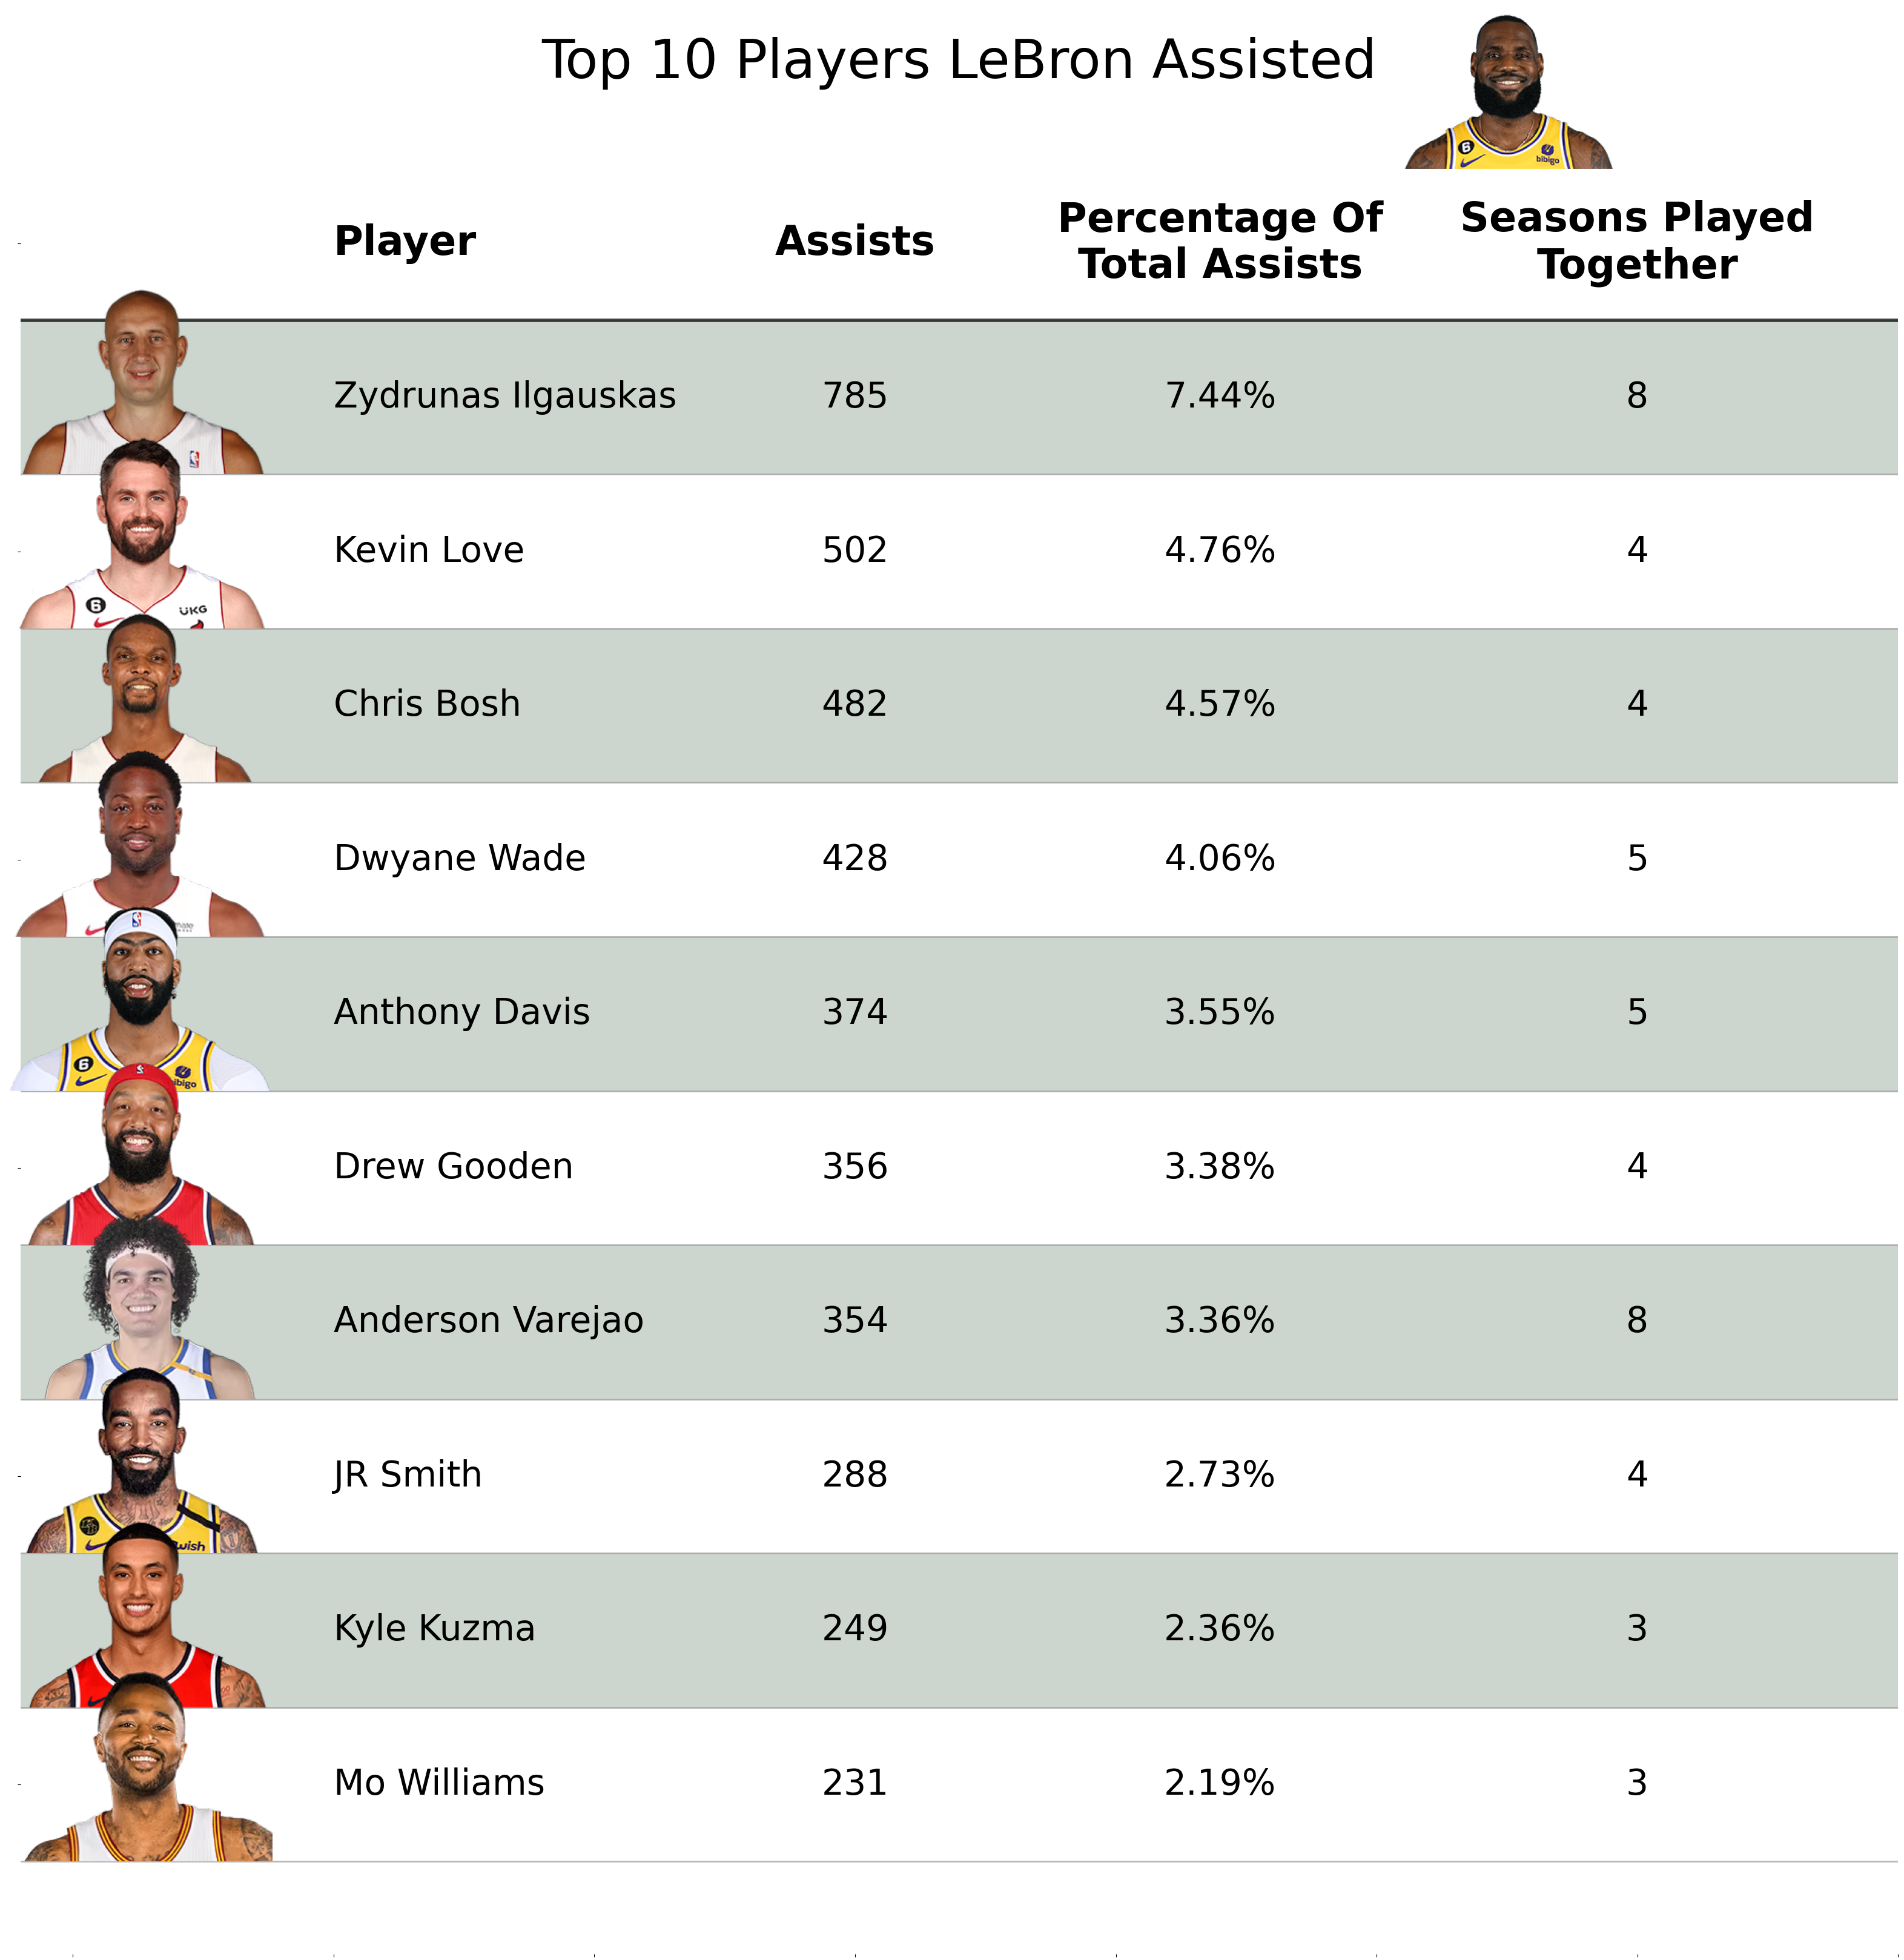

In [168]:
fig = plt.figure(figsize=(40,40))
ax = plt.subplot()

def get_player_img(player_id, zoom):
    #print(path)
    return OffsetImage(plt.imread(f'player_imgs/{player_id}.png'), zoom=zoom)

number_size = 42
font_size = 36
font_title = 48
title_size = 64
zoom = 1.2

top = 10
stop = 10

total_ast = lebron_assits.COUNT.sum()
for i, (player, value) in enumerate(sorted_lebron_dict.items()):
    ast, seasons_played = value
    if i == 10:
        break
    # item = sorted_top10_scorers.iloc[i]
    try:
        player_id = find_players_by_full_name(player)[0]['id']
    except Exception:
        continue
    y_coord = top - i - 1
    if i % 2 == 1:
        color = '#CCD6CE'
        rect = Rectangle((-4.5, y_coord + 0.5), width=10, height=1, fill=True, color=color)
        ax.add_patch(rect)
    
    ab = AnnotationBbox(get_player_img(player_id, zoom=zoom), (0.13, y_coord + 0.122), frameon=False)
    ax.add_artist(ab)
    #ax.text(x=0.25, y=y_coord, ha='left', va='center', s=item.SEASON, size=font_size)
    ax.text(x=0.5, y=y_coord, ha='left', va='center', s=player, size=number_size)
    ax.axhline(y=y_coord-0.5, xmin=-0.25, xmax=12, color='#A0A0A0', alpha=0.75, lw=2)
    
    perc_ast = np.round((ast / lebron_assits.COUNT.sum()) * 100, 2)
    
    ax.text(x=1.5, y=y_coord, ha='center', va='center', s=f"{ast}", size=number_size)
    ax.text(x=2.2, y=y_coord, ha='center', va='center', s=f"{perc_ast}%", size=number_size)
    ax.text(x=3, y=y_coord, ha='center', va='center', s=f"{seasons_played}", size=number_size)

    # ax.text(x=2.2, y=y_coord, ha='center', va='center', s=f"{item.PPP_Transition}", size=number_size)
    # ax.text(x=2.7, y=y_coord, ha='center', va='center', s=f"{item.PPP_Postup}", size=number_size)
    # ax.text(x=3.2, y=y_coord, ha='center', va='center', s=f"{item.PTS}", size=number_size, weight='bold')
    
ax.text(x=0.5, y=top, s='Player', ha='left', va='center', size=font_title, weight='bold')
ax.text(x=1.5, y=top, ha='center', va='center', s="Assists", size=font_title, weight='bold')
ax.text(x=2.2, y=top, ha='center', va='center', s="Percentage Of\nTotal Assists", size=font_title, weight='bold')
ax.text(x=3, y=top, ha='center', va='center', s="Seasons Played\nTogether", size=font_title, weight='bold')
# ax.text(x=2.7, y=top, ha='center', va='center', s="Postup\n(PPP)", size=font_title, weight='bold')
# ax.text(x=3.2, y=top, ha='center', va='center', s="PPG", size=font_title, weight='bold')

ax.axhline(y=top-0.5, xmin=-0.25, xmax=10, color='black', alpha=0.75, lw=4)
ax.set_title("Top 10 Players LeBron Assisted", size=title_size)
# plt.suptitle("(Top 10 players in points per game)", size=title_size-10, y=0.999)

ab = AnnotationBbox(get_player_img(2544, zoom=1), (2.75, 11), frameon=False)
ax.add_artist(ab)
    
ax.set_ylim(bottom=-1.1, top=top+1)
ax.set_xlim(left=-0.1, right=3.5)
ax.grid(False)
ax.set_frame_on(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.savefig('Graphs/lebron_ast.png', bbox_inches='tight')

In [ ]:
plt.pie(lebron_dict.values(), labels = lebron_dict.keys(), autopct='%.0f%%')
plt.show()